<a href="https://colab.research.google.com/github/zayo1511/SimulacionProcesosFinancieros/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerías

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis

#Datos iniciales

In [2]:
# Descargar datos históricos de precios ajustados para BITO y S&P 500
bito_data = yf.download("BITO", start="2021-01-01", end=pd.Timestamp.today())
sp500_data = yf.download("^GSPC", start="2021-01-01", end=pd.Timestamp.today())

# Calcular retornos logarítmicos diarios usando precios ajustados de cierre
bito_data['Returns'] = np.log(bito_data['Adj Close'] / bito_data['Adj Close'].shift(1))
sp500_data['Returns'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))

# Limpiar datos faltantes
bito_data.dropna(inplace=True)
sp500_data.dropna(inplace=True)

# Descarga de datos para simulación MC posterior
stockData = yf.download("BITO", start='2020-01-01')["Adj Close"]
log_returns = np.log(stockData / stockData.shift(1))

# Imprimir una muestra de los datos para verificar
print(bito_data[['Adj Close', 'Returns']].head())
print()
print(sp500_data[['Adj Close', 'Returns']].head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price                      Adj Close   Returns
Ticker                          BITO          
Date                                          
2021-10-21 00:00:00+00:00  20.009579 -0.058274
2021-10-22 00:00:00+00:00  19.362688 -0.032863
2021-10-25 00:00:00+00:00  19.887068  0.026722
2021-10-26 00:00:00+00:00  19.632231 -0.012897
2021-10-27 00:00:00+00:00  18.652084 -0.051215

Price                        Adj Close   Returns
Ticker                           ^GSPC          
Date                                            
2021-01-05 00:00:00+00:00  3726.860107  0.007058
2021-01-06 00:00:00+00:00  3748.139893  0.005694
2021-01-07 00:00:00+00:00  3803.790039  0.014738
2021-01-08 00:00:00+00:00  3824.679932  0.005477
2021-01-11 00:00:00+00:00  3799.610107 -0.006576


#Indicadores sobre el ETF

In [3]:
# Volatilidad histórica anualizada usando ventana de 30 días
bito_data['Volatility'] = bito_data['Returns'].rolling(window=30).std() * np.sqrt(252)
volatility = bito_data['Volatility'].mean()
expected_return = bito_data['Returns'].mean() * 252  # Rendimiento promedio anualizado

# Parámetros de simulación con tasa libre de riesgo de 4.5%
S0 = bito_data['Adj Close'].iloc[-1]  # Precio actual de BITO
r = 0.045  # Tasa libre de riesgo ajustada al 4.5%

# Impresión de resultados para verificar los cálculos
print(f"Último precio de cierre de BITO (S0): {S0}")
print(f"Volatilidad anualizada promedio (volatility): {volatility}")
print(f"Rendimiento promedio anualizado (expected_return): {expected_return}")
print(f"Tasa libre de riesgo utilizada (r): {r}")


Último precio de cierre de BITO (S0): Ticker
BITO    24.66
Name: 2024-11-15 00:00:00+00:00, dtype: float64
Volatilidad anualizada promedio (volatility): 0.5738368679112206
Rendimiento promedio anualizado (expected_return): 0.049127728058704384
Tasa libre de riesgo utilizada (r): 0.045


# Valuaciuón de opciones y estrategia (straddle)

In [4]:
# Supongamos que el precio de ejercicio (K) es el precio actual S0
K = S0
T_straddle = 1/12  # Horizonte de 1 mes para el straddle
volatility = volatility  # Volatilidad histórica promedio

# Funciones para calcular las primas usando el modelo de Black-Scholes
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Calcular la prima del straddle
call_price = black_scholes_call(S0, K, T_straddle, r, volatility)
put_price = black_scholes_put(S0, K, T_straddle, r, volatility)
straddle_price = call_price + put_price

print(f"Precio de la call: {call_price.values[0]}")
print(f"Precio de la put: {put_price.values[0]}")
print(f"Costo inicial del straddle: {straddle_price.values[0]}")


Precio de la call: 1.6713332706101358
Precio de la put: 1.579031445271026
Costo inicial del straddle: 3.2503647158811617


# Simulación para aproximación de ganancia de la estrategia

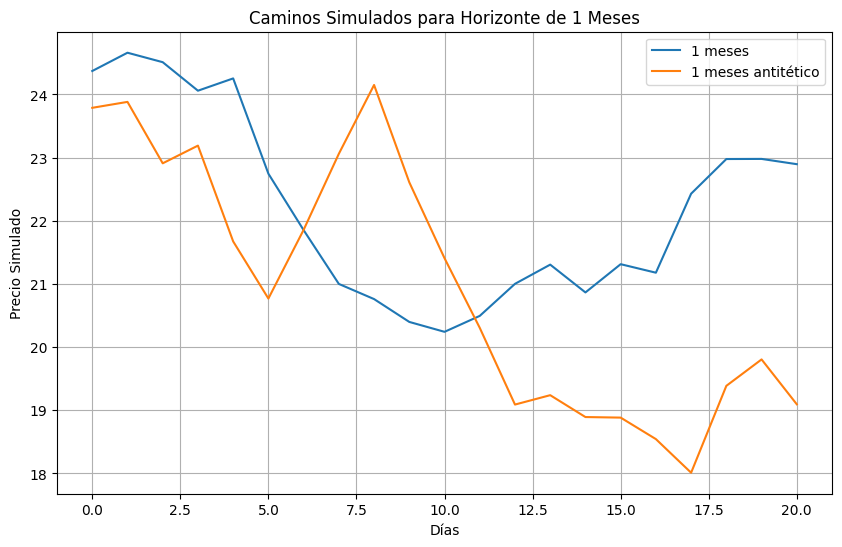

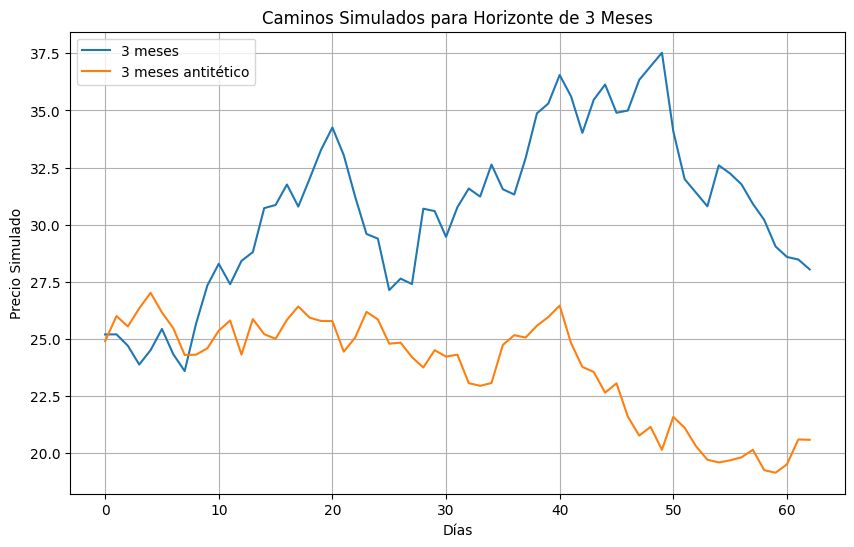

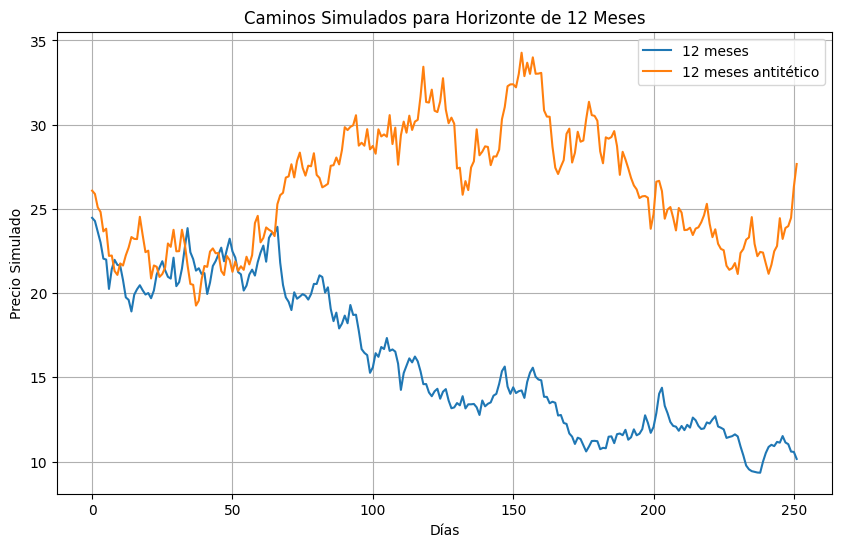

In [5]:
# Parámetros de Monte Carlo
np.random.seed(15)
n_sim = 1000
horizons = [1/12, 3/12, 1]  # 1 mes, 3 meses y 1 año
dt = 1/252  # Paso diario

# Convierte expected_return, volatility y S0 a escalares si son Series o DataFrames
S0 = S0.values[0] if hasattr(S0, "values") else S0
expected_return = expected_return.values[0] if hasattr(expected_return, "values") else expected_return
volatility = volatility.values[0] if hasattr(volatility, "values") else volatility

# Simulación de caminos de precios para cada horizonte
for T in horizons:
    paths = []
    for _ in range(n_sim):
        rand = np.random.normal(0, 1, int(T / dt))
        path = S0 * np.exp(np.cumsum((expected_return - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * rand))
        paths.append(path)

    # Visualización de algunos caminos simulados
    plt.figure(figsize=(10, 6))
    plt.plot(paths[0], label=f"{int(T*12)} meses")
    plt.plot(paths[1], label=f"{int(T*12)} meses antitético")
    plt.title(f"Caminos Simulados para Horizonte de {int(T*12)} Meses")
    plt.xlabel("Días")
    plt.ylabel("Precio Simulado")
    plt.legend()
    plt.grid()
    plt.show()

    print()

In [6]:
# Cálculo de ganancias al vencimiento
profits = [max(path[-1] - K.values[0], 0) + max(K.values[0] - path[-1], 0) - straddle_price.values[0] for path in paths]

# Ganancia esperada y su intervalo de confianza al 95%
mean_profit = np.mean(profits)
conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]

# Cálculo del Ratio de Sharpe
sharpe_ratio = mean_profit / np.std(profits)

# Imprimir resultados
print(f"Ganancia esperada: {mean_profit}")
print(f"Intervalo de confianza al 95%: {conf_interval}")
print(f"Ratio de Sharpe: {sharpe_ratio}")


Ganancia esperada: 7.766926652510546
Intervalo de confianza al 95%: [-2.830676081831972, 37.13854001529574]
Ratio de Sharpe: 0.7647997373371507


# Evaluación de estrategia

## Evaluación retrospectiva

In [7]:
# Escenarios para evaluación
time_frames = [30, 90, 360]  # Horizontes temporales en días
past_prices = stockData  # Usando precios históricos
initial_price_today = stockData.iloc[-1, 0]  # Precio actual

# Primer escenario: Estrategia retrospectiva (usando precios históricos)
print("Evaluación retrospectiva (usando precios históricos):")
for days in time_frames:
    if len(past_prices) > days:  # Asegurarse de que existan datos suficientes
        past_price = past_prices.iloc[-days]  # Precio hace 'days' días
        profit_past = max(past_price.values[0] - K.values[0], 0) + max(K.values[0] - past_price.values[0], 0) - straddle_price.values[0]
        pct_profit_past = profit_past / straddle_price.values[0] * 100
        print(f"Horizonte hace {days} días: Ganancia estimada = ${profit_past:.2f}, Porcentaje = {pct_profit_past:.4f}%")
    else:
        print(f"Horizonte hace {days} días: No hay datos suficientes.")

Evaluación retrospectiva (usando precios históricos):
Horizonte hace 30 días: Ganancia estimada = $4.28, Porcentaje = 131.7125%
Horizonte hace 90 días: Ganancia estimada = $5.53, Porcentaje = 170.0538%
Horizonte hace 360 días: Ganancia estimada = $13.60, Porcentaje = 418.2793%


## Evaluación prospectiva

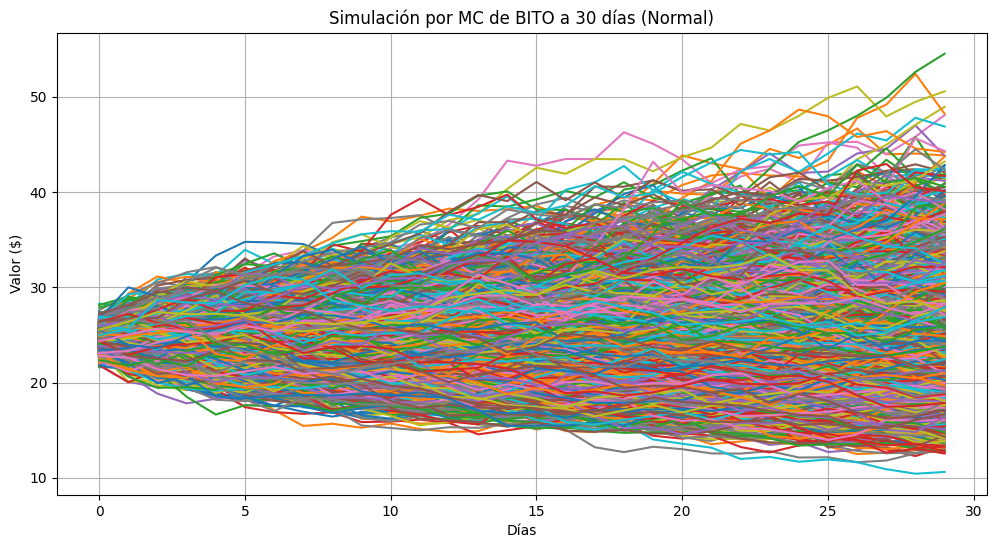

Simulación Normal:
Intervalo de confianza al 95%
[16.04955975 35.97809812]
El precio de la acción esperado a 30 días es:
24.721270456020928



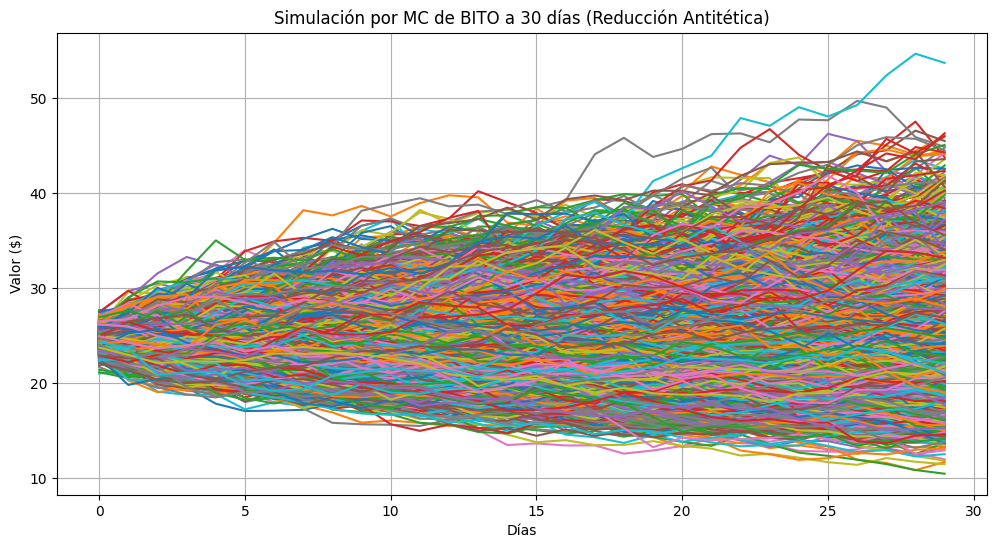

Simulación Antitética:
Intervalo de confianza al 95%
[16.30292003 36.64042784]
El precio de la acción esperado a 30 días es:
24.894340457533406

Evaluación de la estrategia:
Horizonte 30 días (Simulación Normal):
  Ganancia esperada = $0.78, Porcentaje = 24.0867%
  Intervalo de confianza al 95% = [-3.10015338  8.35695873]
Horizonte 30 días (Simulación Antitética):
  Ganancia esperada = $0.81, Porcentaje = 25.0608%
  Intervalo de confianza al 95% = [-3.05466745  8.80441318]



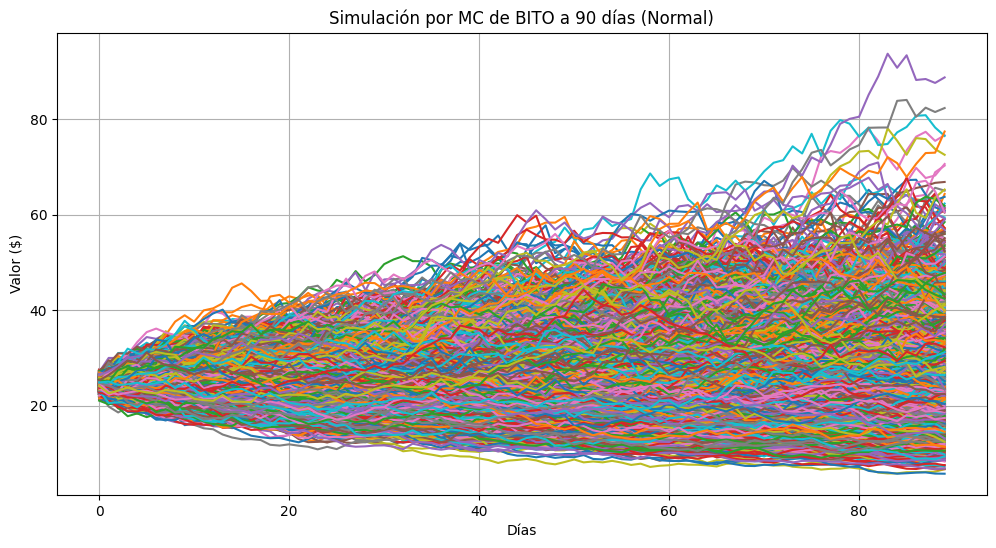

Simulación Normal:
Intervalo de confianza al 95%
[11.52885752 46.91170795]
El precio de la acción esperado a 90 días es:
25.17230205156572



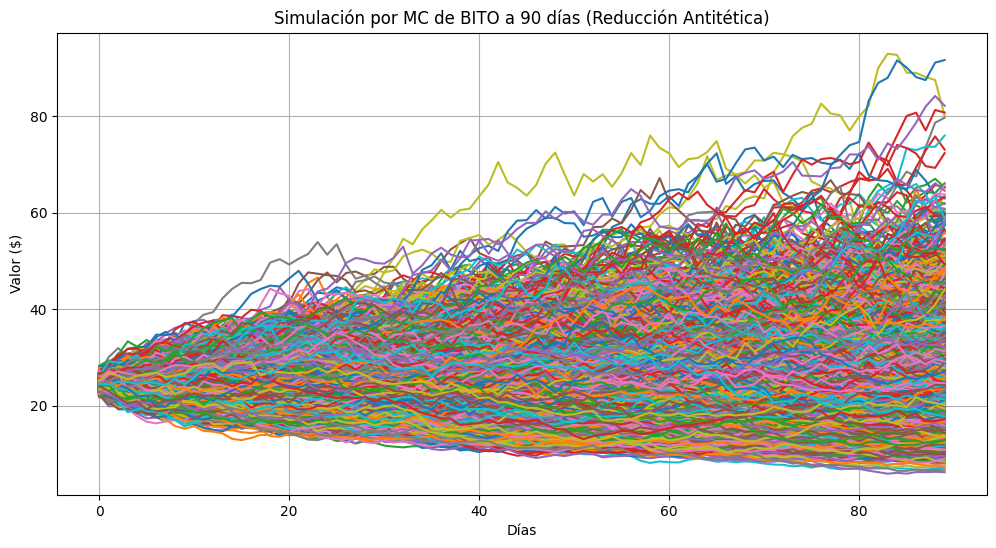

Simulación Antitética:
Intervalo de confianza al 95%
[11.81150148 47.7783594 ]
El precio de la acción esperado a 90 días es:
25.10239895924258

Evaluación de la estrategia:
Horizonte 90 días (Simulación Normal):
  Ganancia esperada = $3.90, Porcentaje = 120.1180%
  Intervalo de confianza al 95% = [-2.91668279 19.00134339]
Horizonte 90 días (Simulación Antitética):
  Ganancia esperada = $3.91, Porcentaje = 120.4286%
  Intervalo de confianza al 95% = [-2.97992154 19.86799484]



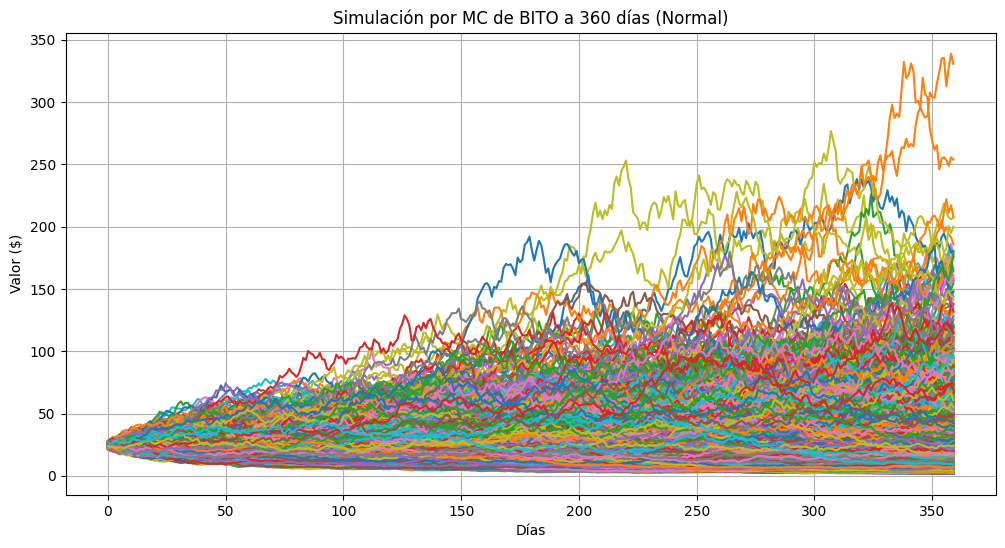

Simulación Normal:
Intervalo de confianza al 95%
[ 5.08769516 83.52433509]
El precio de la acción esperado a 360 días es:
26.749112022455776



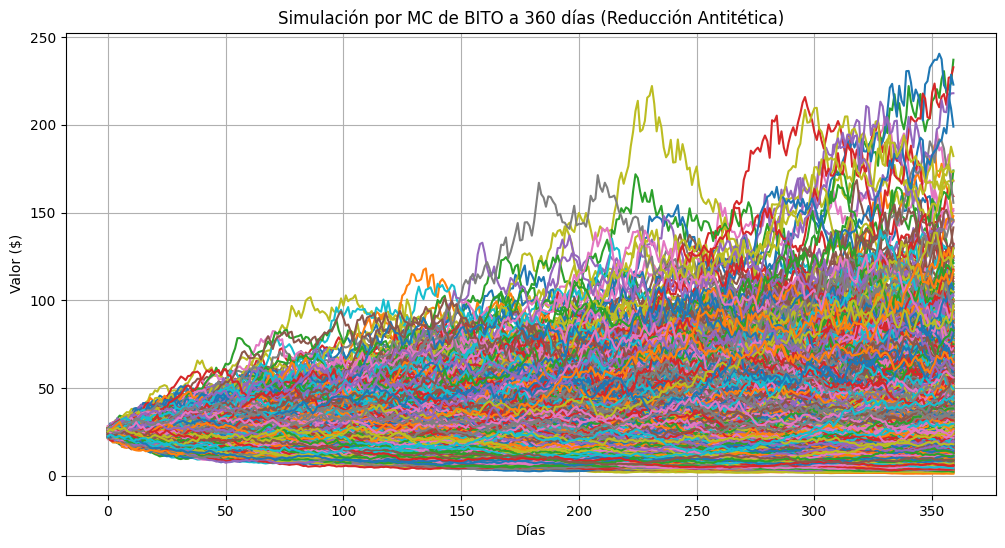

Simulación Antitética:
Intervalo de confianza al 95%
[ 5.03814695 82.70214517]
El precio de la acción esperado a 360 días es:
26.292924734283606

Evaluación de la estrategia:
Horizonte 360 días (Simulación Normal):
  Ganancia esperada = $11.26, Porcentaje = 346.3307%
  Intervalo de confianza al 95% = [-2.65795014 55.61397053]
Horizonte 360 días (Simulación Antitética):
  Ganancia esperada = $10.92, Porcentaje = 336.0303%
  Intervalo de confianza al 95% = [-2.71828136 54.79178061]



In [8]:
# Valor Esperado y Varianza
expected_return = log_returns.mean()
volatility_squared = log_returns.var()

# Estableciendo parámetros de simulación
np.random.seed(15)
T = [30, 90, 360]  # Horizontes en días
mc_sims = 5000  # Número de simulaciones
initial_price = stockData.iloc[-1, 0]

for i in T:
    daily_sims = np.full(shape=(i, mc_sims * 2), fill_value=0.0)  # Espacio para simulaciones normales y antitéticas

    for m in range(mc_sims):
        Z = np.random.normal(size=i)  # Choques aleatorios para los T días
        Z_antithetic = -Z  # Valores antitéticos

        # Simulación original
        dailyReturns = expected_return.values[0] + np.sqrt(volatility_squared.values[0]) * Z
        daily_sims[:, m] = np.cumprod(dailyReturns + 1) * initial_price

        # Simulación antitética
        dailyReturns_antithetic = expected_return.values[0] + np.sqrt(volatility_squared.values[0]) * Z_antithetic
        daily_sims[:, mc_sims + m] = np.cumprod(dailyReturns_antithetic + 1) * initial_price

    # Análisis del último día: separando normal y antitética
    final_day_prices_normal = daily_sims[-1, :mc_sims]
    final_day_prices_antithetic = daily_sims[-1, mc_sims:]

    # Gráfica para simulaciones normales
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sims[:, :mc_sims])
    plt.ylabel('Valor ($)')
    plt.xlabel('Días')
    plt.title('Simulación por MC de BITO a ' + str(i) + ' días (Normal)')
    plt.grid()
    plt.show()

    print("Simulación Normal:")
    print("Intervalo de confianza al 95%")
    print(np.percentile(final_day_prices_normal, [2.5, 97.5]))
    print("El precio de la acción esperado a " + str(i) + " días es:")
    print(final_day_prices_normal.mean())
    print()

    # Gráfica para simulaciones antitéticas
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sims[:, mc_sims:])
    plt.ylabel('Valor ($)')
    plt.xlabel('Días')
    plt.title('Simulación por MC de BITO a ' + str(i) + ' días (Reducción Antitética)')
    plt.grid()
    plt.show()

    print("Simulación Antitética:")
    print("Intervalo de confianza al 95%")
    print(np.percentile(final_day_prices_antithetic, [2.5, 97.5]))
    print("El precio de la acción esperado a " + str(i) + " días es:")
    print(final_day_prices_antithetic.mean())
    print()

    # Evaluación de la estrategia para ambos métodos
    profits_normal = [
        max(price - K.values[0], 0) + max(K.values[0] - price, 0) - straddle_price.values[0]
        for price in final_day_prices_normal
    ]
    profits_antithetic = [
        max(price - K.values[0], 0) + max(K.values[0] - price, 0) - straddle_price.values[0]
        for price in final_day_prices_antithetic
    ]

    mean_profit_normal = np.mean(profits_normal)
    conf_interval_normal = np.percentile(profits_normal, [2.5, 97.5])
    pct_mean_profit_normal = mean_profit_normal / straddle_price.values[0] * 100

    mean_profit_antithetic = np.mean(profits_antithetic)
    conf_interval_antithetic = np.percentile(profits_antithetic, [2.5, 97.5])
    pct_mean_profit_antithetic = mean_profit_antithetic / straddle_price.values[0] * 100

    print("Evaluación de la estrategia:")
    print(f"Horizonte {i} días (Simulación Normal):")
    print(f"  Ganancia esperada = ${mean_profit_normal:.2f}, Porcentaje = {pct_mean_profit_normal:.4f}%")
    print(f"  Intervalo de confianza al 95% = {conf_interval_normal}")
    print(f"Horizonte {i} días (Simulación Antitética):")
    print(f"  Ganancia esperada = ${mean_profit_antithetic:.2f}, Porcentaje = {pct_mean_profit_antithetic:.4f}%")
    print(f"  Intervalo de confianza al 95% = {conf_interval_antithetic}")
    print()
